In [14]:
import awkward as ak
import os
import keras
import numpy as np
import uproot
import nbimporter
import import_ipynb
import matplotlib.pyplot as plt
from hffrag import fixedbinning
from hffrag import binneddensity
from numpy.lib.recfunctions import structured_to_unstructured
import tensorflow as tf
import DeepSetNeuralNet3 as DeepSetNeuralNet


In [15]:
%matplotlib inline 

In [16]:
path = "/home/physics/phujdj/DeepLearningParticlePhysics/CheckPoints/DeepNetWeights&Biases-{epoch:04d}.ckpt"
checkpoint = os.path.dirname(path)
latest_DeepNet = tf.train.latest_checkpoint(checkpoint)


In [17]:
#The data is being stored in a tree datastructure. 
#We access the charm root using this command
tree = uproot.open("hffrag.root:CharmAnalysis")

In [18]:
MAXEVENTS = 1e20
MAXTRACKS = 32
LR = 1e-3

In [19]:
#Read in the data from the root file
track_features = ["AnalysisTracks_pt","AnalysisTracks_eta","AnalysisTracks_phi","AnalysisTracks_z0sinTheta","AnalysisTracks_d0sig","AnalysisTracks_d0","AnalysisTracks_d0sigPV","AnalysisTracks_d0PV"]
jet_features = ["AnalysisAntiKt4TruthJets_pt", "AnalysisAntiKt4TruthJets_eta", "AnalysisAntiKt4TruthJets_phi",
                "AnalysisAntiKt4TruthJets_ghostB_pt", "AnalysisAntiKt4TruthJets_ghostB_eta","AnalysisAntiKt4TruthJets_ghostB_phi"]
features = tree.arrays(jet_features+track_features,entry_stop = MAXEVENTS)

In [20]:
#Select the events of interest
events = features[ak.sum(features["AnalysisAntiKt4TruthJets_pt"] > 25000, axis = 1) > 0]

In [21]:
#Displays the number of jets being trained on
jets = events[jet_features][:,0]
print("The number of jets to train on is: ", len(jets))

#Select tracks from the events
tracks = events[track_features]

#Match the tracks to the jets
matchedtracks = tracks[DeepSetNeuralNet.Match_Tracks(jets,tracks)]

#Pad and Flatten the data
matchedtracks = DeepSetNeuralNet.flatten(matchedtracks, MAXTRACKS)

# Identify the the bottom jets and their associated tracks
bjets = ak.sum(jets["AnalysisAntiKt4TruthJets_ghostB_pt"] > 5000, axis=1) > 0
jets = jets[bjets]
bhads_pt = jets["AnalysisAntiKt4TruthJets_ghostB_pt"][:, 0].to_numpy()
bhads_eta = jets["AnalysisAntiKt4TruthJets_ghostB_eta"][:,0].to_numpy()
bhads_phi = jets["AnalysisAntiKt4TruthJets_ghostB_phi"][:,0].to_numpy()
bhads = np.stack([bhads_pt,bhads_eta,bhads_phi],axis = -1)

print("There are {} outputs".format(np.shape(bhads)[1]))
matchedtracks = matchedtracks[bjets]
print("There are {} inputs".format(np.shape(matchedtracks)[1]))

#Transform the jet and tracks to unstructed data.
jets = structured_to_unstructured(jets[jet_features[:-3]])
matchedtracks = structured_to_unstructured(matchedtracks)

#Fix the angles
jets = DeepSetNeuralNet.pt_eta_phi_2_px_py_pz_jets(jets).to_numpy()
tracks_p = DeepSetNeuralNet.pt_eta_phi_2_px_py_pz_tracks(matchedtracks.to_numpy())
bhads = DeepSetNeuralNet.pt_eta_phi_2_px_py_pz_jets(bhads)
print(np.shape(tracks_p))
print(np.shape(matchedtracks[:, :, 3:]))
tracks = np.concatenate([tracks_p,matchedtracks[:,:,3:].to_numpy()],axis = 2)

The number of jets to train on is:  141329
There are 3 outputs
There are 32 inputs
(68143, 32, 3)
(68143, 32, 5)


DeepSetNeuralNet3.ipynb:16: RuntimeWarning: overflow encountered in sinh
  "2022-11-24 17:04:14.084053: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory\n",


In [22]:
#Builds the deep neural network
track_layers = [32,32,32,32,32]
jet_layers = [64,64,64,64,64]
DeepNet = DeepSetNeuralNet.DeepSetNeuralNetwork(
    [len(track_features)]+track_layers, jet_layers,3,LR)
DeepNet.summary()

2022-11-24 17:15:02.368581: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-24 17:15:02.368610: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-24 17:15:02.368627: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (vonneumann.csc.warwick.ac.uk): /proc/driver/nvidia/version does not exist
2022-11-24 17:15:02.368859: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 8)]         0         
                                                                 
 masking (Masking)           (None, None, 8)           0         
                                                                 
 time_distributed (TimeDistr  (None, None, 8)          72        
 ibuted)                                                         
                                                                 
 batch_normalization (BatchN  (None, None, 8)          32        
 ormalization)                                                   
                                                                 
 time_distributed_1 (TimeDis  (None, None, 32)         288       
 tributed)                                                       
                                                             

In [23]:
DeepNet.load_weights(latest_DeepNet)
#Specify the neural network's optimizer and loss function
#loss = DeepNet.evaluate(tracks,bhads,verbose = 2)
#print("The Loaded DeepNet has loss: ", round(loss,3))

In [24]:
#Load the training and validation data
X_train = np.load("/home/physics/phujdj/DeepLearningParticlePhysics/TrainingAndValidationData/X_train_data.npy")
X_valid = np.load("/home/physics/phujdj/DeepLearningParticlePhysics/TrainingAndValidationData/X_valid_data.npy")
y_train = np.load("/home/physics/phujdj/DeepLearningParticlePhysics/TrainingAndValidationData/y_train_data.npy")
y_valid = np.load("/home/physics/phujdj/DeepLearningParticlePhysics/TrainingAndValidationData/y_valid_data.npy")
# Have the model predict the total momentum of the b tracks
predictions = DeepNet.predict(tracks)
predictions_train = DeepNet.predict(X_train)
predictions_valid = DeepNet.predict(X_valid)

639/639 [==============================] - 1s 1ms/step


In [25]:
# Output the first 10 guesses
print(predictions[:10])
print(np.shape(predictions))
print(bhads[:10])

[[ 7.2921609e+04  2.9183701e-02  1.4096123e+00]
 [ 6.6849992e+04 -4.0090513e-01  1.1223978e+00]
 [ 6.2996234e+04  3.1368464e-01 -1.1264600e-01]
 [ 4.4002371e+04  4.2449057e-02 -1.8245092e-01]
 [ 4.9400043e+04 -6.4561822e-02 -4.8075944e-01]
 [ 7.7090258e+04  7.3238671e-02  1.7474425e+00]
 [ 4.5605711e+04  6.6177472e-02  1.5167917e+00]
 [ 4.9766316e+04  1.8987358e-03  2.9669988e-01]
 [ 5.4342719e+04 -6.2701851e-03 -3.7578782e-01]
 [ 1.1286768e+05 -1.2277529e-01  1.6513808e+00]]
(68143, 3)
[[  48855.56531144  128363.19160447  124938.01790683]
 [    843.45625286   77133.74792279  179693.16123271]
 [ -77645.8243511   -61246.03310984 -543946.69198392]
 [  14105.86372119  -28270.27862345    3567.73767912]
 [  19637.04494914  -28563.57486597  -26376.60331503]
 [ -30646.74970554   73222.93169604  -33788.85654509]
 [  60390.6973391    56997.81220067  325654.38520138]
 [ -72178.99726066  -68222.88070912 -175227.83127402]
 [  45643.80086696  -12164.6048607    17055.60480696]
 [ -75954.8230627   12

In [26]:
# Output the first 10 guesses
print(predictions_train[:10])
print(np.shape(predictions_train))
print(y_train[:10])

[[ 4.6842164e+04  1.1935660e-01  4.0410444e-02]
 [ 9.3995219e+04 -4.4406801e-01  1.1726502e+00]
 [ 5.5391102e+04  2.4237210e-01  3.0632579e-01]
 [ 4.8004902e+04  9.1236591e-02  8.8445520e-01]
 [ 7.0401516e+04  6.6707927e-01 -1.8311167e-01]
 [ 6.0215062e+04  2.5566575e-01 -3.8784337e-01]
 [ 6.2952383e+04  2.4631569e-01 -1.0711916e-01]
 [ 5.8539293e+04  2.2258922e-01 -3.1991336e-01]
 [ 7.4754367e+04  7.6228040e-01 -5.1210326e-01]
 [ 5.2330660e+04  7.9118043e-02 -9.2695326e-02]]
(47700, 3)
[[ 2.25837148e+04 -1.11829448e+00 -2.89107251e+00]
 [ 1.02303289e+05 -4.66148943e-01  1.52025747e+00]
 [ 8.82068594e+04  2.64114261e-01 -3.02909970e+00]
 [ 2.86915645e+04 -8.56954098e-01  3.08979154e+00]
 [ 2.46381016e+04 -5.95648133e-04 -9.33090866e-01]
 [ 8.03538359e+04 -1.47286355e+00 -7.02692986e-01]
 [ 8.16023516e+04 -6.14633150e-02 -2.47428823e+00]
 [ 5.66446133e+04 -2.88459492e+00  1.38768625e+00]
 [ 8.60839688e+04 -1.81367052e+00 -9.18767273e-01]
 [ 7.29591641e+04  8.20199132e-01 -3.01786900e-01

In [27]:
# Output the first 10 guesses
print(predictions_valid[:10])
print(np.shape(predictions_valid))
print(y_valid[:10])

[[ 5.2735812e+04 -6.3086979e-02  1.8942778e+00]
 [ 5.1853746e+04  5.2252799e-02  1.2161128e-01]
 [ 5.9810645e+04  5.9982300e-02  3.0594987e-01]
 [ 3.9048316e+04 -1.1216588e-01  3.3394456e-01]
 [ 5.1990645e+04  9.5029771e-03  2.2980039e-01]
 [ 5.2790527e+04 -7.5292401e-02  1.2125562e+00]
 [ 3.5623082e+04 -2.8041825e-02  1.1984326e+00]
 [ 6.3645266e+04  3.4352714e-01 -9.2151737e-01]
 [ 4.1834734e+04  6.7236602e-02  1.1643026e+00]
 [ 4.7226785e+04 -8.1042945e-04  1.1463307e+00]]
(20443, 3)
[[ 6.26302266e+04  1.10172701e+00  1.39337587e+00]
 [ 5.62574375e+04 -5.77646911e-01 -2.24327636e+00]
 [ 1.52007500e+05  1.08551276e+00 -1.99092984e+00]
 [ 4.21772656e+04  8.27166021e-01 -2.23249483e+00]
 [ 1.72101836e+04 -4.44836348e-01 -2.65001941e+00]
 [ 3.92732930e+04 -1.30336273e+00  1.52333128e+00]
 [ 4.78160039e+04 -4.17539179e-01  2.90553498e+00]
 [ 1.17628555e+05  1.50948226e+00 -5.52145004e-01]
 [ 4.54671094e+04  1.39630878e+00  5.49972475e-01]
 [ 5.78298594e+04  8.62816036e-01  8.31534028e-01

In [28]:
#Assesses the error and pull in the transverse momentum predictions by the neural network
error_pt_train = (predictions_train[:, 0] - y_train[:,0])
#pull_pt_train = error_pt_train/np.exp(predictions_train[:, 3])

# Compares and constrasts the true and predicted momentums
print(np.min(predictions_train[:,0]),np.max(predictions_train[:,0]))

print("Mean and standard deviation")
print("The mean/std for the ppred - ptrue: ", np.mean(error_pt_train), np.std(error_pt_train))
#print("The mean/std for the pull", np.mean(pull_pt_train), np.std(pull_pt_train))


23045.518 328418.9
Mean and standard deviation
The mean/std for the ppred - ptrue:  -20007.3382587604 32862.82995902802


In [29]:
print(np.shape(predictions_valid))
print(np.shape(X_valid))
print(np.shape(y_valid))

(20443, 3)
(20443, 32, 8)
(20443, 3)


In [30]:
#Assesses the error and pull in the transverse momentum predictions by the neural network
error_pt_valid = (predictions_valid[:, 0] - y_valid[:,0])
#pull_pt_valid = error_pt_valid/np.exp(predictions_valid[:, 3])

# Compares and constrasts the true and predicted momentums
print(np.min(predictions_valid[:,0]),np.max(predictions_valid[:,0]))

print("Mean and standard deviation")
print("The mean/std for the ppred - ptrue: ", np.mean(error_pt_valid), np.std(error_pt_valid))
#print("The mean/std for the pull", np.mean(pull_pt_valid), np.std(pull_pt_valid))

26951.535 268068.97
Mean and standard deviation
The mean/std for the ppred - ptrue:  -19768.156228145217 33191.05466269878


In [31]:
#Assesses the error and pull in the transverse momentum predictions by the neural network
error_pt = (predictions[:, 0] - bhads[:,0])
#pull_pt = error_pt/np.exp(predictions[:, 3])

# Compares and constrasts the true and predicted momentums
print(np.min(predictions[:,0]),np.max(predictions[:,0]))

print("Mean and standard deviation")
print("The mean/std for the ppred - ptrue: ", np.mean(error_pt), np.std(error_pt))
#print("The mean/std for the pull", np.mean(pull_pt), np.std(pull_pt))

23045.518 328418.9
Mean and standard deviation
The mean/std for the ppred - ptrue:  62006.23251495412 66698.9313483824


In [32]:
#Assesses the error and pull in the transverse momentum predictions by the neural network
error_eta_train = (predictions_train[:, 1] - y_train[:,1])
#pull_eta_train = error_pt_train/np.exp(predictions_train[:, 4])

# Compares and constrasts the true and predicted momentums
print(np.min(predictions_train[:,1]),np.max(predictions_train[:,1]))

print("Mean and standard deviation")
print("The mean/std for the ppred - ptrue: ", np.mean(error_eta_train), np.std(error_eta_train))
#print("The mean/std for the pull", np.mean(pull_eta_train), np.std(pull_eta_train))

-1.0666558 1.4529605
Mean and standard deviation
The mean/std for the ppred - ptrue:  0.1306881357877651 1.2518390042953937


In [33]:
#Assesses the error and pull in the transverse momentum predictions by the neural network
error_eta_valid = (predictions_valid[:, 1] - y_valid[:,1])
#pull_eta_valid = error_pt_valid/np.exp(predictions_valid[:, 4])

# Compares and constrasts the true and predicted momentums
print(np.min(predictions_valid[:,1]),np.max(predictions_valid[:,1]))

print("Mean and standard deviation")
print("The mean/std for the ppred - ptrue: ", np.mean(error_eta_valid), np.std(error_eta_valid))
#print("The mean/std for the pull", np.mean(pull_eta_valid), np.std(pull_eta_valid))

-1.0857346 1.4300957
Mean and standard deviation
The mean/std for the ppred - ptrue:  0.12445696602253277 1.2445501636703782


In [34]:
#Assesses the error and pull in the transverse momentum predictions by the neural network
error_eta = (predictions[:, 1] - bhads[:,1])
#pull_eta = error_eta/np.exp(predictions[:, 4])

# Compares and constrasts the true and predicted momentums
print(np.min(predictions_valid[:,1]),np.max(predictions_valid[:,1]))

print("Mean and standard deviation")
print("The mean/std for the ppred - ptrue: ", np.mean(error_eta_valid), np.std(error_eta_valid))
#print("The mean/std for the pull", np.mean(pull_eta_valid), np.std(pull_eta_valid))

-1.0857346 1.4300957
Mean and standard deviation
The mean/std for the ppred - ptrue:  0.12445696602253277 1.2445501636703782


In [35]:
#Assesses the error and pull in the transverse momentum predictions by the neural network
error_phi_train = (predictions_train[:, 2] - y_train[:,2])
#pull_phi_train = error_pt_train/np.exp(predictions_train[:, 5])

# Compares and constrasts the true and predicted momentums
print(np.min(predictions_train[:,2]),np.max(predictions_train[:,2]))

print("Mean and standard deviation")
print("The mean/std for the ppred - ptrue: ", np.mean(error_phi_train), np.std(error_phi_train))
#print("The mean/std for the pull", np.mean(pull_phi_train), np.std(pull_phi_train))

-2.6207738 3.5639493
Mean and standard deviation
The mean/std for the ppred - ptrue:  0.5791283420123324 1.4871833844023483


In [36]:
#Assesses the error and pull in the transverse momentum predictions by the neural network
error_phi_valid = (predictions_valid[:, 2] - y_valid[:,2])
#pull_phi_valid = error_phi_valid/np.exp(predictions_valid[:, 5])

# Compares and constrasts the true and predicted momentums
print(np.min(predictions_valid[:,2]),np.max(predictions_valid[:,2]))

print("Mean and standard deviation")
print("The mean/std for the ppred - ptrue: ", np.mean(error_phi_valid), np.std(error_phi_valid))
#print("The mean/std for the pull", np.mean(pull_phi_valid), np.std(pull_phi_valid))

-2.1265168 3.6702347
Mean and standard deviation
The mean/std for the ppred - ptrue:  0.5667181807880811 1.4904320543160428


In [38]:
#Assesses the error and pull in the transverse momentum predictions by the neural network
error_phi = (predictions[:, 2] - bhads[:,2])
#pull_phi = error_phi/np.exp(predictions[:, 5])

# Compares and constrasts the true and predicted momentums
print(np.min(predictions[:,2]),np.max(predictions[:,2]))

print("Mean and standard deviation")
print("The mean/std for the ppred - ptrue: ", np.mean(error_phi), np.std(error_phi))
#print("The mean/std for the pull", np.mean(pull_phi), np.std(pull_phi))

-2.6207738 3.6702347
Mean and standard deviation
The mean/std for the ppred - ptrue:  679.8846683249213 197673.08882820295


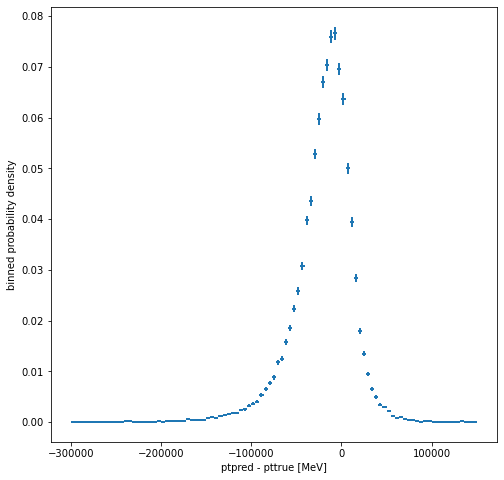

In [39]:
#Plot the distribution of tranverse momentum error.
fig = binneddensity(error_pt_train, fixedbinning(-300000, 150000, 100),
                    xlabel="ptpred - pttrue [MeV]")
fig

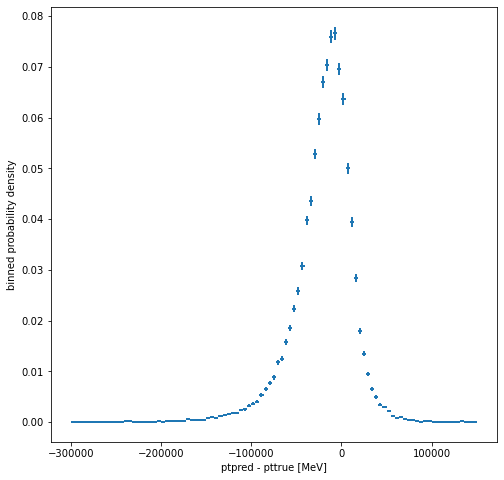

In [40]:
#Plot the distribution of tranverse momentum error.
fig = binneddensity(error_pt_train, fixedbinning(-300000, 150000, 100),
                    xlabel="ptpred - pttrue [MeV]")
fig

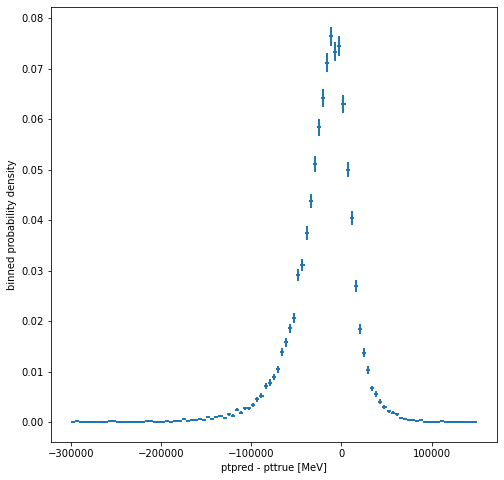

In [41]:
#Plot the distribution of tranverse momentum error.
fig = binneddensity(error_pt_valid, fixedbinning(-300000, 150000, 100),
                    xlabel="ptpred - pttrue [MeV]")
fig

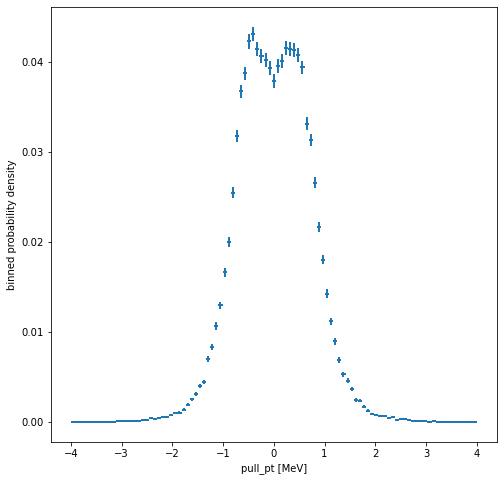

In [ ]:
#Plot the distribution of tranverse momentum error.
fig = binneddensity(pull_pt, fixedbinning(-4.0, 4.0, 100),
                    xlabel="pull_pt [MeV]")
fig

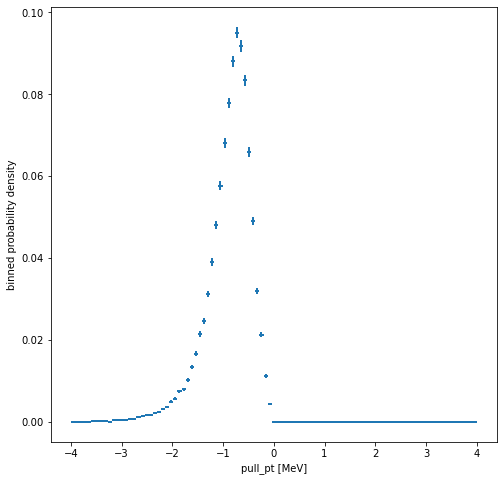

In [ ]:
#Plot the distribution of tranverse momentum error.
fig = binneddensity(pull_pt_train, fixedbinning(-4.0, 4.0, 100),
                    xlabel="pull_pt [MeV]")
fig

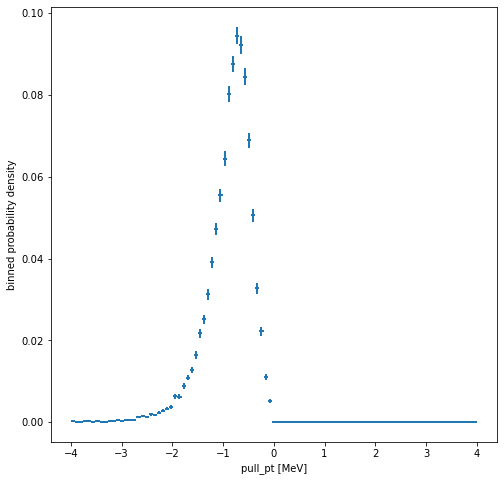

In [ ]:
#Plot the distribution of tranverse momentum error.
fig = binneddensity(pull_pt_valid, fixedbinning(-4.0, 4.0, 100),
                    xlabel="pull_pt [MeV]")
fig

/home/physics/phujdj/DeepLearningParticlePhysics/hffrag.py:63: RuntimeWarning: invalid value encountered in true_divide
  ys = ys / s
/home/physics/phujdj/DeepLearningParticlePhysics/hffrag.py:64: RuntimeWarning: invalid value encountered in true_divide
  yerrs = yerrs / s
/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


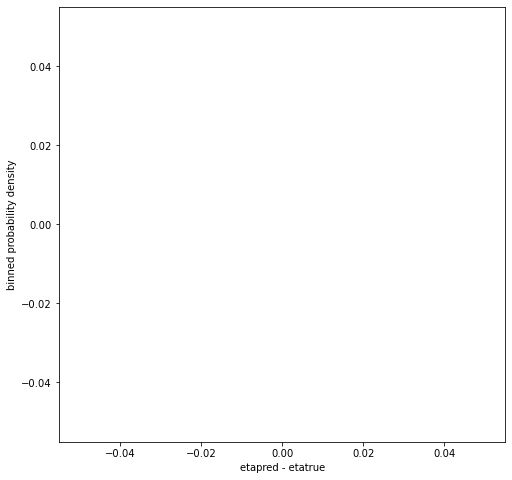

In [45]:
#Plot the distribution of tranverse momentum error.
fig = binneddensity(error_eta, fixedbinning(1000000, 1000000, 100),
                    xlabel="etapred - etatrue")
fig

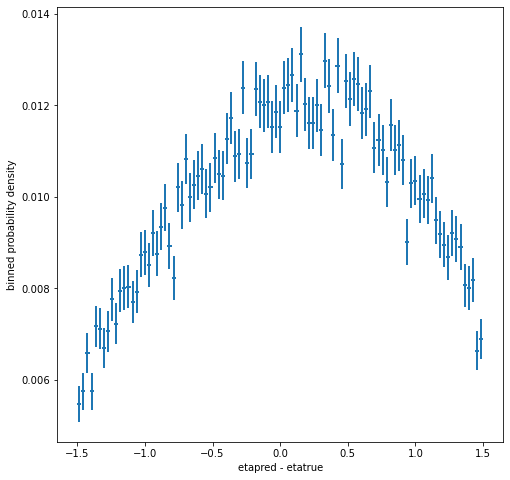

In [46]:
#Plot the distribution of tranverse momentum error.
fig = binneddensity(error_eta_train, fixedbinning(-1.5, 1.5, 100),
                    xlabel="etapred - etatrue")
fig

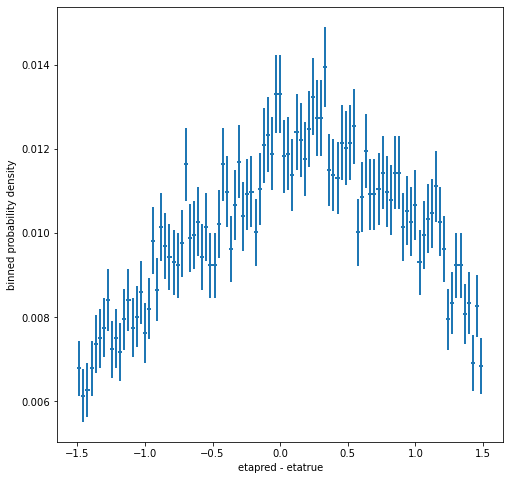

In [47]:
#Plot the distribution of tranverse momentum error.
fig = binneddensity(error_eta_valid, fixedbinning(-1.5, 1.5, 100),
                    xlabel="etapred - etatrue")
fig

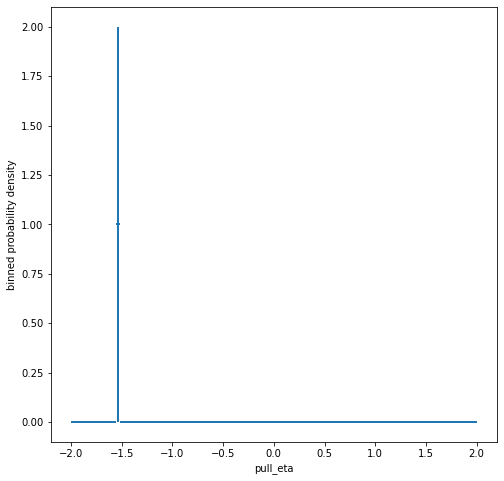

In [ ]:
#Plot the distribution of tranverse momentum error.
fig = binneddensity(pull_eta, fixedbinning(-2, 2, 100),
                    xlabel="pull_eta")
fig

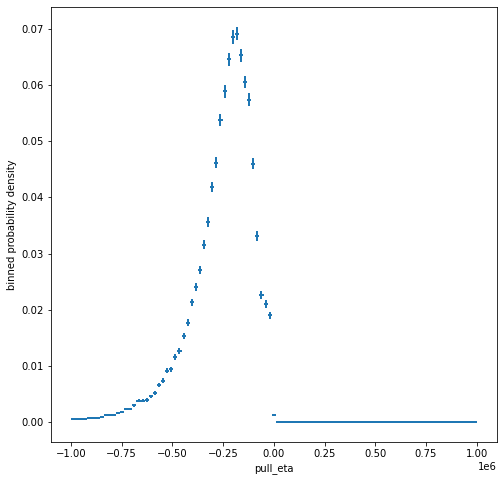

In [ ]:
#Plot the distribution of tranverse momentum error.
fig = binneddensity(pull_eta_train, fixedbinning(-1000000, 1000000, 100),
                    xlabel="pull_eta")
fig

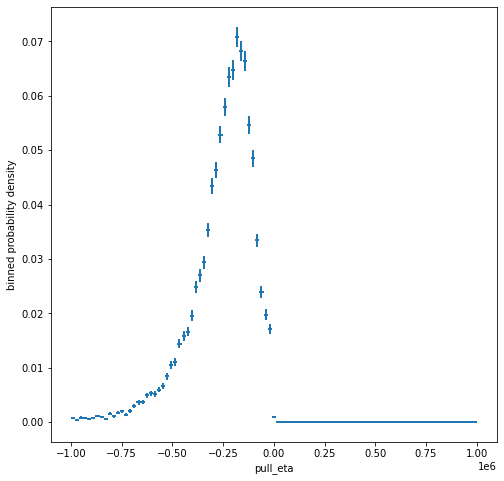

In [ ]:
#Plot the distribution of tranverse momentum error.
fig = binneddensity(pull_eta_valid, fixedbinning(-1000000, 1000000, 100),
                    xlabel="pull_eta")
fig

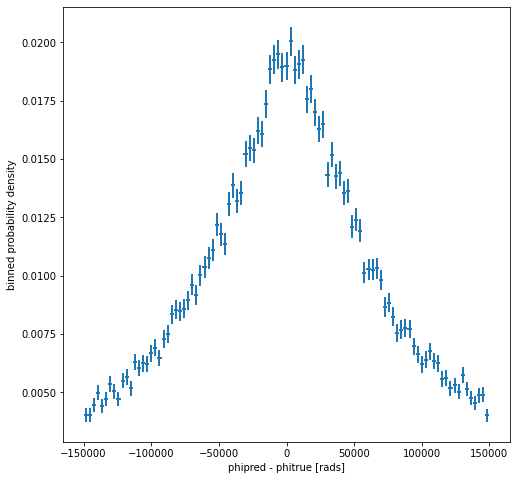

In [48]:
#Plot the distribution of phi errors
fig = binneddensity(error_phi, fixedbinning(-150000, 150000, 100),
                    xlabel="phipred - phitrue [rads]")
fig

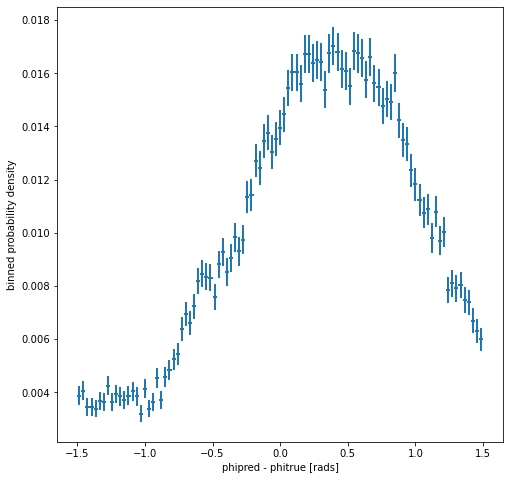

In [49]:
#Plot the distribution of phi errors
fig = binneddensity(error_phi_train, fixedbinning(-1.5, 1.5, 100),
                    xlabel="phipred - phitrue [rads]")
fig

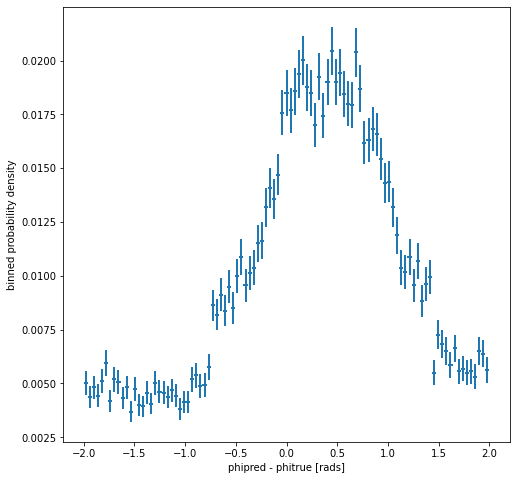

In [50]:
#Plot the distribution of phi errors
fig = binneddensity(error_phi_valid, fixedbinning(-2, 2, 100),
                    xlabel="phipred - phitrue [rads]")
fig

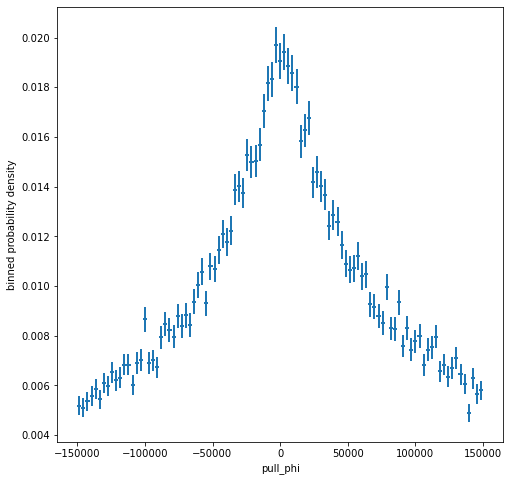

In [ ]:
#Plot the distribution of phi errors
fig = binneddensity(pull_phi, fixedbinning(-150000, 150000, 100),
                    xlabel="pull_phi")
fig

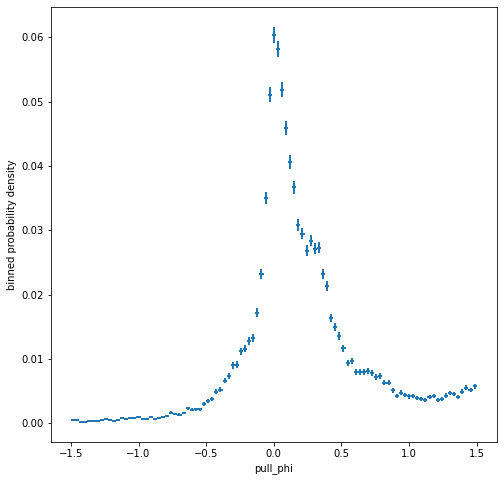

In [ ]:
#Plot the distribution of phi errors
fig = binneddensity(error_phi_train, fixedbinning(-1.5, 1.5, 100),
                    xlabel="pull_phi")
fig

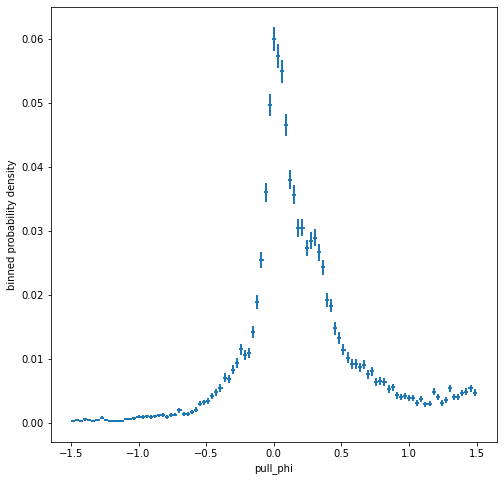

In [ ]:
#Plot the distribution of phi errors
fig = binneddensity(error_phi_valid, fixedbinning(-1.5, 1.5, 100),
                    xlabel="pull_phi")
fig

In [51]:
#Evaluate the entire performance of the model
loss = DeepNet.evaluate(tracks,bhads,verbose = 2)
print("The Loaded DeepNet has loss: ", loss,3)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unexpected EOF while parsing (<unknown>, line 1)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unexpected EOF while parsing (<unknown>, line 1)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2130/2130 - 3s - loss: 17216266240.0000 - Normal_Accuracy_Metric: 319.4535 - 3s/epoch - 2ms/step
The Loaded DeepNet has loss:  [17216266240.0, 319.4534912109375] 3
